# Presented by Computer Vision Consulting 
### Client: Motional Inc.

Author                                                                                                                       
Data Scientist: Stefano Caruso 



# Overview 
###  Pedestrian classification Model for Motional
Our clint Motional has been able to advance autonomous vehicle(AV) technology to the point where their driverless vehicles have driven 1.5 million miles and completed 100,000 passenger trips on public roadways – without a single at-fault accident.

Pedestrian detection is a small subset to the much larger field of object detection that is essential for numerous applications such as person tracking, intelligent surveillance system, abnormal scene detection and our focus today autonomous driving along with many more. 

Datasets trained on the basic person detection problem contains only images labelled with person objects. 

Training with this type of dataset leads to many false positives while testing on images that include other objects close to the main target which in this case is a person. Anything near the person can throw off the model negatively. 

We obtained a dataset for addressing the false positives that occur during the person detection process. 
Some objects have very similar features to those of a person. If a model is trained using a dataset containing only persons, it leads to several false positives since it cannot differentiate such objects from that of a person. This dataset includes person and person-like objects. Person-like objects that we introduce in our dataset are statues, mannequins, scarecrows, and robots.

## Business Understanding

Billions of people jump in their car every morning and drive to work or run arrands for the day. Moving effortlessly throughout numerous cities across the world. 
At some point during the day we are confronted by a pedestrian walking a dog, in a parking lot, at a cross walk not realizing how complex our vision is. We detect movement at the slightest glance and instantly calculate if there is danger. Clearly humans make mistakes but our vision is very accuracte, we can not say the same for computer vision unless trained properly it might be more efficient and that is our task at hand, to use machine learning to improve a model that detects pedestrians for our client "MOTIONAL". 

Computer Vision consulting (Stefano Caruso) will be representing Motional, the task is to provide a accuracte pedestrian detection machine learning model that I will first trian on person / person like because of its quality and results. 
Motional must pass government regulation and state level saftey laws prior to autonomous driving in real world applications.

Pedestrian detection is a key factor for the automotive industry to obtain autonomous driving, with over one billion vehicles worldwide, some say the goal is to have them all be autonomous to make the roads a safer place. Before this happens, we need to start with computer vision and image classification.

The problem is a vehicle needs to detect all images accurately or it could lead to system malfunction or worse casualties. 
We use ML, specifically computer vision to detect pedestrians in many industries including autonomous driving, security surveillance, train stations, cross walks and many more useful applications. 

Tesla has started the revolution for autonomous driving, other automotive manufacturers are scrambling to hire top engineers to join their team and build the technology efficiently. Not only is it difficult for the AI to detect pedestrians the speed at which is does the calculation is of great importance. 

The impact would not only make the roads safer, it will calculate the best route, save lives, create countless jobs and free up time for other task.

During exploration of the topic I reviewed these resources for a deep understanding of the field and industry of autonomous driving and Pedestrian detection with CNN model utilization. 

https://www.frontiersin.org/articles/10.3389/fnbot.2018.00064/full

https://www.researchgate.net/profile/Tomaso-Poggio-2/publication/2467374_A_Trainable_Pedestrian_Detection_System/links/0fcfd50e6dd305e726000000/A-Trainable-Pedestrian-Detection-System.pdf




My passion for AI/ML motivated me to use neural networks for pedestrian detection to learn new skills in this sector of machine learning field and explore how useful these methods can be in real world and how large the impact can be across landscapes. 


## Environment replication 
Located in my https://github.com/stefanocaruso0101/PedestrianDetection github remote repo is a folder named "Environment" inside that folder you will find a file named "Pedestrian_ENV.yml" where you can download and save the environment file in your repo to utilize the libraries that I used for this project. Essenitally you will be creating a new environment locally on git that you can use for the imports and code below.
In the follow cell are my imports along with descriptions of the library functionality in the comments below each import.

To smoothly replicate, start with adding a folder locally in your repo called "Environment" then save and copy my file name "Pedestrian_ENV.yml" into your new folder "Environment". Navigate to git and copy this code to create the environment.

1: Code to active your environment file in git command line :
- MacOS: run conda env create -f Pedestrian_ENV.yml
- Windows: run conda env create -f Pedestrian_ENV.yml

2: Activation:
- conda activate Ped_Env



Now that the environment is completed push all your changes to github. 


In [1]:
import numpy as np 
# used for numeric datatypes and speed for iteration 

import pandas as pd 
# data package 

import cv2 
# assign values to vector and resize 

import os 
# access directory 

from xml.etree import ElementTree 
# import to read/locate xml elemnts 

from matplotlib import pyplot as plt
# visual library 

import tensorflow as tf
# neural network library 

from sklearn.metrics import confusion_matrix
#visual for true positive, true negative, false positive, false negative(how many times the model was correct and wrong)

from sklearn.metrics import accuracy_score

from tensorflow.keras import datasets, layers, models
# model creation 

from tensorflow.keras.regularizers import l2
# regualize a model that is overfit

keras = tf.keras
# Neural net library 

from sklearn.metrics import recall_score
# display metric scores for model performance 

## Reducing size for the first model to speed up training, original size is 500,442

In [2]:
# reduction size 
size = (75, 50)

## Data replication instructions

First create your local repo, remote repo in github (add a .gitignore python file to your github during creation) and connect them together. Then create a folder in your local repo called "Data" this is where we will store the data after downloading and extracting / unzipping.

Dataset link: https://www.kaggle.com/datasets/karthika95/pedestrian-detection?select=Train

After clicking the kaggle dataset link, scroll down until you locate the tab on the right 'Data Explorer' you will find 3 smaller tabs test, train, validation, download all three of these folders. Save the downloaded directories to the new folder in your local repo "Data", now unzip/extract the directory and rename it "Pdata". Now we want to make sure we dont push all these images to the github, we do that by using the .gitignore python file you created, simply open the .gitignore python file and scroll to the very bottom and type the directory name where all the new data is stored, in this case are folder name is "Pdata", done. Using these same file names and code will allow you to replicate the project and how the data is loaded into the notebook. Now open a jupyter notebook and load the data in but first we must create a function to help link all the annotation xml labels to the correct image. Normally we would use a Imagedatagenerator but we have to link the labels to the images.tions 


## Create a function 
to load in data and label the classes person or person like, rescale, resize and speed up model building while tuning params.


In [3]:
# create a function 
def load_data(size=size):
    
    # datasets variable list of the 3 folders for train,test and validation
    datasets = ['Train/Train', 'Test/Test', 'Val/Val'] 
    
    #list to append the function
    output = []
   
    
    for dataset in datasets:
        
        images = [] # create list
        labels = [] # create list 
        
        # adding the dataset loop to the file path of Annotations(xml files)
        directoryANNOTATE = "Data/Pdata/" + dataset + "/Annotations/" 
        
        # adding the dataset loop to file path of images 
        directoryIMGAGES = "Data/Pdata/" + dataset + "/JPEGImages/" 
        
        # listdir() returns a list containing the names of the entries in the directory given by path, now we can loop it
        file = os.listdir(directoryANNOTATE) 
        jpg = os.listdir(directoryIMGAGES) 
        
        # organizing the annotations files to match the image order so the classes are labeled corrrctly to each image
        file.sort() 
        
        # organizing the images to match the order of the xml so the images are labeled correctly(person,like person)
        jpg.sort() 
        
        
        i = 0
        
        # loop through the xml files(file_) 
        #we need to match and idenify the class of each image by matching it with the annotation xml file
        for xml in file:
            
            # combining the annotations with the xml 
            xmlf = os.path.join(directoryANNOTATE,xml)
            
            # ElementTree represents the whole XML folder as a tree, and Element represents a single node in this tree. 
            dom = ElementTree.parse(xmlf)
            
            # iteriate through the xml annotations files and locate object element
            objct = dom.findall('object')  
            
            # from the object element now locate name element in the xml annotation file and only take the first object
            label_name = objct[0].find('name').text 
            
            # this will append all text either 'person / person like' found in the xml file
            # inside the name element, and saved off to the labeled_class 
            labels.append(labeled_class[label_name]) 
          
            # directory for images and the list of images to loop through
            img_path = directoryIMGAGES + jpg[i] 
            
            # taking rbg color value and assigning to tensor(3 dim matrix) (image data generator)
            curr_img = cv2.imread(img_path)
            
            
            # resize the org image to my custom perference 
            curr_img = cv2.resize(curr_img, size)
            
            
            #append the list of images that have been resized 
            images.append(curr_img) 
           
            
            # +1 to after the loop is completed it will move on to the next image to classify 
            i +=1
            
        # creating a numpy array of tensors, instead of list of tensors
        images = np.array(images, dtype='float32')
        
        
        # normalizing all images so the pixel values are between 0-1(image data generator)
        images = images / 255
        
        
        
        
        # tranforming the list of tensor to a numpy array.
        labels = np.array(labels, dtype='int32')
        
        
        # creating the list and joining together the labels and images
        output.append((images, labels)) 
       
    return output

In [4]:
classes = ['person','person-like'] 
# text to locate inside the xml person or person like

labeled_class = {class_name:i for i, class_name in enumerate(classes)} 
# setting up the dict keys person/personlike, iteriate and save the class labels 'person,person like'

n_classes = 2 
# 2 classes person or person like




size = (75,50)
#resizing the image to speed up model, actually image pixel size is (500,442)

## Customize a visual function 
convenience of reviewing many epcohs and tracking the error and accuracy of both training and validation. 

In [5]:
# visual function to review the training acc score vs validation score, also the loss to see if we can minimize error

def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "train_loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


In [6]:
# loading in the data with the function
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

## Data Understanding
I have researched multiple pedestrian datasets and have choose a dataset that first classifies person or person like, because this prepares the models in advanced before being active in real world. 

First create your local repo, remote repo in github (add a .gitignore python file to your github during creation) and connect them together. Then create a folder in your local repo called "Data" this is where we will store the data after downloading and extracting / unzipping. 

Dataset link:
https://www.kaggle.com/datasets/karthika95/pedestrian-detection?select=Train

After clicking the kaggle dataset link, scroll down until you locate the tab on the right 'Data Explorer' you will find 3 smaller tabs test, train, validation, download all three of these folders. Save the downloaded directories to the new folder in your local repo "Data", now unzip/extract the directory and rename it "Pdata". Now we want to make sure we dont push all these images to the github, we do that by using the .gitignore python file you created, simply open the .gitignore python file and scroll to the very bottom and type the directory name where all the new data is stored, in this case are folder name is "Pdata", done. 
Using these same file names and code will allow you to replicate the project and how the data is loaded into the notebook.
Now open a jupyter notebook and load the data in but first we must create a function to help link all the annotation xml labels to the correct image. Normally we would use a Imagedatagenerator but we have to link the labels to the images. 

This project has found value in the dataset from Kaggle for the pedestrian detection images because we have over 1,300 images total and it specifically targets person or person like which is more relevant for a model to be trained on, when training a model only on pedestrians, there can be error such a statues, costume displays for advertisement, billboards with painting of people or even objects shaped similar of people. 

Motional’s top concern for autonomous driving is pedestrian detection. When the model is trained properly it will detect all pedestrians and monover safely throughout the streets without accicedences, saving lives and resources, 
Additional projects have been performed on this dataset, I will contribute by training a more accurate model that will be better prepared for deployment in real time autonomous driving.

A minor limitation is we could use more images from multi cities around the world because different cultures do have different person like objects throughout the streets but this is of little concern our current market is USA. Also more data would have allowed our test and validation size to be greater which is always a good thing for training on larger data for more accuracy.


## Confirmation of images and label size match up. 

In [7]:
# confirm train size
train_images.shape

(944, 50, 75, 3)

In [8]:
# confirm label size matches image size (train_label = annotation xml files with class indication person or person_like)
train_labels.shape

(944,)

In [9]:
# reviewing image size (pixels) and how many images are in the validation folder 
val_images.shape

(160, 50, 75, 3)

In [10]:
val_labels.shape

(160,)

In [11]:
test_labels.shape

(235,)

In [12]:
# reviewing image size (pixels) and how many images are in the test folder 
test_images.shape

(235, 50, 75, 3)

## Data Preparation
The data is stored in three separate directories containing images split into training, validation, and test. There is also annotations folders that labels (classify) the images written in xml. We must connect each image with the correct xml for data to be feed into the model correctly.
The data states the classification of each image in the annotation folder(xml file). 
Goal is to use the data given to train a model will an efficient accuracy metric.
Creating a function that connects the image class with the actual jpeg image. Within that function we will also have a resize method to speed up the model iterations. Place the image values of red, blue and green on a tensor with their values. This is how the models vision decides what the color and image actually. 
Matching the annotation class with the correct images. 
Our split is divided up into three, 944 images for our training, 160 for validation and 235 for testing split.

I resized the data to speed up training time because of the server limitation, rescaling was done to get all the rbg colors for each pixel on the same scale from 0-1, this also speeds up training time. 

## Exploring the data with matplotlib library
class images are person / person like displayed on the header of each photo.

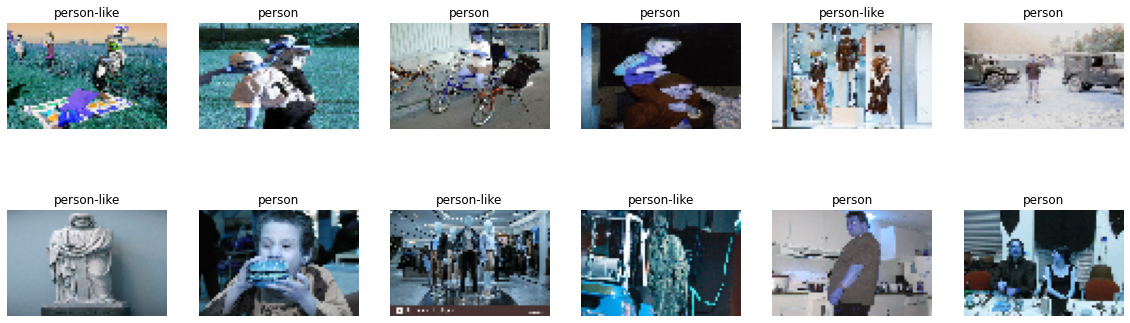

In [13]:
# looking at random images from training data
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),12))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])  
    plt.title(classes[train_labels[i]])
    plt.axis('off')

## Modeling
Build a CNN model to train on the images to address our business problem of pedestrian detection.              
The classes are the target person / person like.
After numerous hyperparameter tuning, A valuable final model will have high accuracy score and reduced error.
A CNN model is good for image classificatoin because the tensorflow can train on 3 channels values well (colors pixels rbg, 3). Also can detect latent features whith CNN.

# Model hyperparameter tuning

Conv2d hyperparameter layout ( filter= learns how to detect features in the image to declare the class 
                
                Kernel= the size of the filter/matrix as it transform the image 
                
                strides= how many vectors the kernel moves across the matrix 
                
                padding=analyzes the image to the edge/corner and beyond by 1 vector to optimize the analysis
                
                activation = takes the output from pervious layer and passes it to the next layer
                
                (transforming the signal based on the function type)
                
                input= pixel shape of image(200,200 matrix) and last digit in this case 3 = rgb(color image scale)
                
                3 values combined in a single pixel will represent the final color the pixel displays
                
                red value = 0, blue= 255, green= 255 this combination will result in yellow
                
                255 is the brightest and highest value, will 1 being most faint, zero results as nonpresent  )
                
                dropout layer to address overfitting, turn off nodes randomly or with a float percentage. 

Flatten is used to flatten the filters and output of my class prediction ( binary )
 1 dense layer and sigmoid is used to get my signal class prediction ( binary, 2 classes person or personlike)

compile
 RMSProp with momentum generates its parameter updates using a momentum on the rescaled gradient,
 binary model only two classes
 specifically optimizing tp & fp want to detect all images correctly (accuracy)

fit
 saving off the model as an object for predicts and scores
 epochs how many time the model completes its training from start to end and backwards
 batch size, how many images the model looks at one time

## Baseline model
Start simple I will add 1 cnn layer, then flatten for mertic results, 2 dense layers and save off the object for evalution. 

In [37]:
# create CNN model Baseline model 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=1, kernel_size=(1,1), activation='relu', input_shape=(50, 75, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])


history = model.fit(train_images, train_labels, epochs=3, batch_size=10,
                    validation_data=(val_images, val_labels))

Epoch 1/3
95/95 [==============================] - 1s 11ms/step - loss: 0.6925 - accuracy: 0.5540 - val_loss: 0.6923 - val_accuracy: 0.5312
Epoch 2/3
95/95 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.5646 - val_loss: 0.6917 - val_accuracy: 0.5312
Epoch 3/3
95/95 [==============================] - 1s 8ms/step - loss: 0.6889 - accuracy: 0.5646 - val_loss: 0.6913 - val_accuracy: 0.5312


## Visual to review 
Accuracy and loss per epoch on both validation and training. 
This will allow us to see if more epochs will result in a better outcome. Attemting to get loss near zero and scores high.

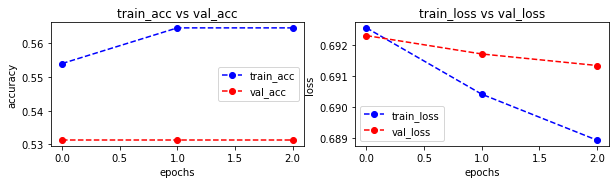

In [38]:
plot_accuracy_loss(history)

## Capturing how many params the first model is training on. 
To high is costly, lower the better but to low the models do not perform well 

In [39]:

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 50, 75, 1)         4         
_________________________________________________________________
flatten_21 (Flatten)         (None, 3750)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 3751      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 2         
Total params: 3,757
Trainable params: 3,757
Non-trainable params: 0
_________________________________________________________________


## Poor score for my baseline model 56% adding CNN layers and padding to have the model train all the way to the edge of each image. Additional CNN layers along with pooling, strides and increased filters to add complexity. Upping the training to 20 epochs.
               

In [40]:
# CNN first model                
model = models.Sequential()
model.add(layers.Conv2D(filters=12, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 75, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy']) 


history_2 = model.fit(train_images, train_labels, epochs=20, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/20
30/30 [==============================] - 5s 164ms/step - loss: 0.6918 - accuracy: 0.5339 - val_loss: 0.6828 - val_accuracy: 0.5375
Epoch 2/20
30/30 [==============================] - 4s 145ms/step - loss: 0.6818 - accuracy: 0.5816 - val_loss: 0.6683 - val_accuracy: 0.5750
Epoch 3/20
30/30 [==============================] - 4s 125ms/step - loss: 0.6678 - accuracy: 0.5985 - val_loss: 0.6480 - val_accuracy: 0.5813
Epoch 4/20
30/30 [==============================] - 4s 125ms/step - loss: 0.6464 - accuracy: 0.6102 - val_loss: 0.6268 - val_accuracy: 0.6687
Epoch 5/20
30/30 [==============================] - 4s 132ms/step - loss: 0.6240 - accuracy: 0.6314 - val_loss: 0.6300 - val_accuracy: 0.6625
Epoch 6/20
30/30 [==============================] - 4s 133ms/step - loss: 0.6075 - accuracy: 0.6504 - val_loss: 0.5969 - val_accuracy: 0.6875
Epoch 7/20
30/30 [==============================] - 4s 131ms/step - loss: 0.5850 - accuracy: 0.6917 - val_loss: 0.7068 - val_accuracy: 0.6187
Epoch 

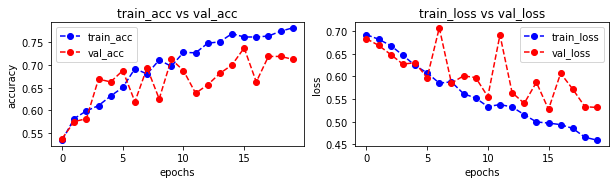

In [41]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_2)

## Increasing the Pixel size and complexity to achieve higher scores. 

In [24]:
# loading in the data
(train_images_2, train_labels_2),(test_images_2, test_labels_2),(val_images_2, val_labels_2) = load_data(size = (200,200))

## Last mode had a score of 78%, Incrasing cnn layers and raising the pixel dimensions. I am underfit and want to close the gap between the validation and training split. ( 200,200)

In [25]:
# CNN model #3 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_3 = model.fit(train_images_2, train_labels_2, epochs=30, batch_size=32,
                    validation_data=(val_images_2, val_labels_2))

Epoch 1/30
30/30 [==============================] - 68s 2s/step - loss: 1.7339 - accuracy: 0.5244 - val_loss: 0.6860 - val_accuracy: 0.5750
Epoch 2/30
30/30 [==============================] - 71s 2s/step - loss: 0.7525 - accuracy: 0.5604 - val_loss: 0.6900 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 71s 2s/step - loss: 0.7170 - accuracy: 0.5900 - val_loss: 0.6826 - val_accuracy: 0.5312
Epoch 4/30
30/30 [==============================] - 73s 2s/step - loss: 0.7211 - accuracy: 0.6600 - val_loss: 1.4940 - val_accuracy: 0.4688
Epoch 5/30
30/30 [==============================] - 72s 2s/step - loss: 0.7190 - accuracy: 0.6059 - val_loss: 0.6201 - val_accuracy: 0.6875
Epoch 6/30
30/30 [==============================] - 73s 2s/step - loss: 0.6900 - accuracy: 0.6822 - val_loss: 0.6176 - val_accuracy: 0.7063
Epoch 7/30
30/30 [==============================] - 73s 2s/step - loss: 0.7304 - accuracy: 0.6441 - val_loss: 0.6587 - val_accuracy: 0.7000
Epoch 8/30
30/30 [==

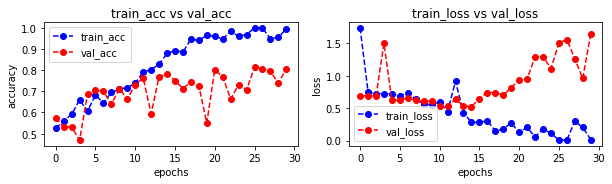

In [26]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_3)

In [27]:
# loading in the data
(train_images_3, train_labels_3),(test_images_3, test_labels_3),(val_images_3, val_labels_3) = load_data(size = (100,80))

In [28]:
train_images_3.shape

(944, 80, 100, 3)

## Last model was better but still overfit.
Reducing pixel dimensions in the middle of my two previous models to hit the sweet spot. (80,100)

In [29]:
# CNN model #4 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(80,100, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_4 = model.fit(train_images_3, train_labels_3, epochs=30, batch_size=32,
                    validation_data=(val_images_3, val_labels_3))

Epoch 1/30
30/30 [==============================] - 16s 524ms/step - loss: 1.0355 - accuracy: 0.5254 - val_loss: 0.6762 - val_accuracy: 0.5875
Epoch 2/30
30/30 [==============================] - 16s 523ms/step - loss: 0.7681 - accuracy: 0.5816 - val_loss: 0.6845 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 16s 520ms/step - loss: 0.7561 - accuracy: 0.5826 - val_loss: 0.6860 - val_accuracy: 0.5375
Epoch 4/30
30/30 [==============================] - 16s 534ms/step - loss: 0.7409 - accuracy: 0.6070 - val_loss: 0.6695 - val_accuracy: 0.7312
Epoch 5/30
30/30 [==============================] - 16s 533ms/step - loss: 0.6680 - accuracy: 0.6133 - val_loss: 2.2430 - val_accuracy: 0.5312
Epoch 6/30
30/30 [==============================] - 16s 528ms/step - loss: 0.7814 - accuracy: 0.5985 - val_loss: 0.6258 - val_accuracy: 0.6875
Epoch 7/30
30/30 [==============================] - 16s 523ms/step - loss: 0.6639 - accuracy: 0.6133 - val_loss: 0.6187 - val_accuracy: 0.7563

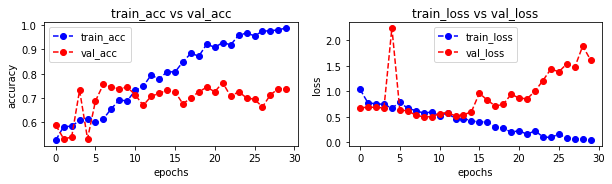

In [30]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_4)

## Overfit is an issue, decreasing cnn layers and dense layer look to close the gap between training and validation scores

In [31]:
# CNN model #5 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=36, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(80,100, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=24, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=12, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_5 = model.fit(train_images_3, train_labels_3, epochs=50, batch_size=32,
                    validation_data=(val_images_3, val_labels_3))

Epoch 1/50
30/30 [==============================] - 8s 282ms/step - loss: 0.7011 - accuracy: 0.5678 - val_loss: 0.6885 - val_accuracy: 0.5312
Epoch 2/50
30/30 [==============================] - 10s 325ms/step - loss: 0.7189 - accuracy: 0.5646 - val_loss: 0.7028 - val_accuracy: 0.5312
Epoch 3/50
30/30 [==============================] - 9s 316ms/step - loss: 0.6666 - accuracy: 0.5646 - val_loss: 0.6692 - val_accuracy: 0.5312
Epoch 4/50
30/30 [==============================] - 9s 304ms/step - loss: 0.6554 - accuracy: 0.5646 - val_loss: 0.6516 - val_accuracy: 0.5312
Epoch 5/50
30/30 [==============================] - 9s 305ms/step - loss: 0.6419 - accuracy: 0.5646 - val_loss: 0.6494 - val_accuracy: 0.5312
Epoch 6/50
30/30 [==============================] - 8s 283ms/step - loss: 0.6289 - accuracy: 0.5498 - val_loss: 0.6633 - val_accuracy: 0.5312
Epoch 7/50
30/30 [==============================] - 8s 261ms/step - loss: 0.6396 - accuracy: 0.5953 - val_loss: 0.6368 - val_accuracy: 0.6375
Epoch

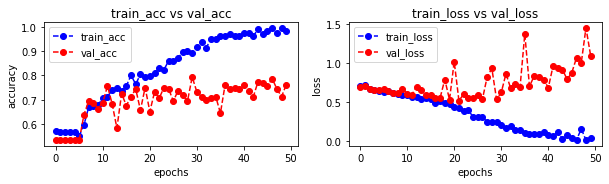

In [41]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_5)

In [43]:
# loading in the data
(train_images_4, train_labels_4),(test_images_4, test_labels_4),(val_images_4, val_labels_4) = load_data(size = (50,50))

## Decreasing the pixel shape to the smallest yet to prevent overfitting and training time.(50,50)
                

In [43]:
# CNN model # 6              
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_6 = model.fit(train_images_4, train_labels_4, epochs=50, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/50
30/30 [==============================] - 6s 189ms/step - loss: 0.7590 - accuracy: 0.5445 - val_loss: 0.6854 - val_accuracy: 0.5312
Epoch 2/50
30/30 [==============================] - 5s 177ms/step - loss: 0.6997 - accuracy: 0.5519 - val_loss: 0.6864 - val_accuracy: 0.5312
Epoch 3/50
30/30 [==============================] - 6s 203ms/step - loss: 0.6736 - accuracy: 0.5890 - val_loss: 0.6750 - val_accuracy: 0.5312
Epoch 4/50
30/30 [==============================] - 6s 203ms/step - loss: 0.7105 - accuracy: 0.5996 - val_loss: 0.6745 - val_accuracy: 0.5312
Epoch 5/50
30/30 [==============================] - 6s 189ms/step - loss: 0.6419 - accuracy: 0.6314 - val_loss: 0.6375 - val_accuracy: 0.7188
Epoch 6/50
30/30 [==============================] - 7s 228ms/step - loss: 0.6023 - accuracy: 0.6621 - val_loss: 0.5309 - val_accuracy: 0.7063
Epoch 7/50
30/30 [==============================] - 6s 205ms/step - loss: 0.6047 - accuracy: 0.7087 - val_loss: 0.5202 - val_accuracy: 0.7437
Epoch 

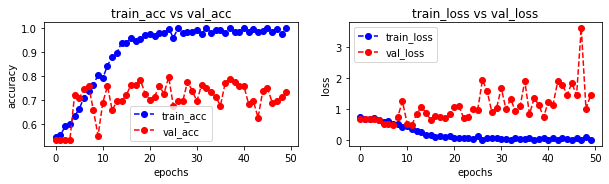

In [44]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_6)

###  Previous and the next The next model I will reduce overfitting by lowering the filter do make the model less complex. Model 7

In [45]:
# create CNN model# 7 (92 train,75 validation smallest gap score) decreasing the cnn layers, adjusting kernal size 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_7 = model.fit(train_images_4, train_labels_4, epochs=120, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/120
30/30 [==============================] - 2s 63ms/step - loss: 0.6870 - accuracy: 0.5498 - val_loss: 0.6804 - val_accuracy: 0.5688
Epoch 2/120
30/30 [==============================] - 1s 48ms/step - loss: 0.6712 - accuracy: 0.5953 - val_loss: 0.6701 - val_accuracy: 0.5813
Epoch 3/120
30/30 [==============================] - 1s 48ms/step - loss: 0.6564 - accuracy: 0.6367 - val_loss: 0.6454 - val_accuracy: 0.6438
Epoch 4/120
30/30 [==============================] - 1s 45ms/step - loss: 0.6407 - accuracy: 0.6398 - val_loss: 0.6437 - val_accuracy: 0.5875
Epoch 5/120
30/30 [==============================] - 1s 45ms/step - loss: 0.6293 - accuracy: 0.6462 - val_loss: 0.6333 - val_accuracy: 0.6250
Epoch 6/120
30/30 [==============================] - 1s 48ms/step - loss: 0.6146 - accuracy: 0.6727 - val_loss: 0.6036 - val_accuracy: 0.6812
Epoch 7/120
30/30 [==============================] - 1s 45ms/step - loss: 0.5953 - accuracy: 0.7044 - val_loss: 0.6126 - val_accuracy: 0.6562
Epoch 

Epoch 115/120
30/30 [==============================] - 2s 52ms/step - loss: 0.2310 - accuracy: 0.9078 - val_loss: 0.6598 - val_accuracy: 0.8062
Epoch 116/120
30/30 [==============================] - 2s 55ms/step - loss: 0.2231 - accuracy: 0.9047 - val_loss: 0.6486 - val_accuracy: 0.7937
Epoch 117/120
30/30 [==============================] - 2s 56ms/step - loss: 0.2209 - accuracy: 0.9153 - val_loss: 0.8325 - val_accuracy: 0.7437
Epoch 118/120
30/30 [==============================] - 2s 51ms/step - loss: 0.2197 - accuracy: 0.9057 - val_loss: 0.7036 - val_accuracy: 0.8000
Epoch 119/120
30/30 [==============================] - 2s 55ms/step - loss: 0.2353 - accuracy: 0.8919 - val_loss: 0.6684 - val_accuracy: 0.7875
Epoch 120/120
30/30 [==============================] - 2s 53ms/step - loss: 0.2075 - accuracy: 0.9142 - val_loss: 0.6853 - val_accuracy: 0.7500


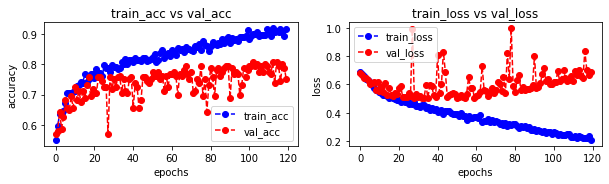

In [46]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_7)

### Switching to swish activation to get the training and validation scores both in the 90s

In [47]:
# create CNN model #8 review a swish activation to prevent overfitting,also swithing optimizer for better performance.                              
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1, 1),padding='same', activation='swish', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='swish'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='swish'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='swish'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_8 = model.fit(train_images_4, train_labels_4, epochs=200, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/200
30/30 [==============================] - 3s 84ms/step - loss: 0.6899 - accuracy: 0.5519 - val_loss: 0.6862 - val_accuracy: 0.5312
Epoch 2/200
30/30 [==============================] - 2s 62ms/step - loss: 0.6777 - accuracy: 0.5900 - val_loss: 0.6612 - val_accuracy: 0.6687
Epoch 3/200
30/30 [==============================] - 2s 60ms/step - loss: 0.6558 - accuracy: 0.6356 - val_loss: 0.6323 - val_accuracy: 0.6625
Epoch 4/200
30/30 [==============================] - 2s 63ms/step - loss: 0.6320 - accuracy: 0.6409 - val_loss: 0.6025 - val_accuracy: 0.6500
Epoch 5/200
30/30 [==============================] - 2s 63ms/step - loss: 0.6185 - accuracy: 0.6483 - val_loss: 0.5797 - val_accuracy: 0.6938
Epoch 6/200
30/30 [==============================] - 2s 59ms/step - loss: 0.6088 - accuracy: 0.6568 - val_loss: 0.5629 - val_accuracy: 0.6750
Epoch 7/200
30/30 [==============================] - 2s 59ms/step - loss: 0.6041 - accuracy: 0.6727 - val_loss: 0.5980 - val_accuracy: 0.6750
Epoch 

30/30 [==============================] - 2s 76ms/step - loss: 0.2537 - accuracy: 0.8867 - val_loss: 0.5871 - val_accuracy: 0.6875
Epoch 115/200
30/30 [==============================] - 2s 67ms/step - loss: 0.2542 - accuracy: 0.8930 - val_loss: 0.5651 - val_accuracy: 0.7000
Epoch 116/200
30/30 [==============================] - 2s 60ms/step - loss: 0.2588 - accuracy: 0.8919 - val_loss: 0.6711 - val_accuracy: 0.7250
Epoch 117/200
30/30 [==============================] - 2s 58ms/step - loss: 0.2526 - accuracy: 0.8972 - val_loss: 0.6458 - val_accuracy: 0.7375
Epoch 118/200
30/30 [==============================] - 2s 62ms/step - loss: 0.2544 - accuracy: 0.8867 - val_loss: 0.6768 - val_accuracy: 0.7188
Epoch 119/200
30/30 [==============================] - 2s 60ms/step - loss: 0.2517 - accuracy: 0.8877 - val_loss: 0.6472 - val_accuracy: 0.7063
Epoch 120/200
30/30 [==============================] - 2s 60ms/step - loss: 0.2371 - accuracy: 0.8930 - val_loss: 0.5956 - val_accuracy: 0.7188
Epoch 

Epoch 171/200
30/30 [==============================] - 2s 64ms/step - loss: 0.1376 - accuracy: 0.9470 - val_loss: 0.8606 - val_accuracy: 0.7500
Epoch 172/200
30/30 [==============================] - 2s 63ms/step - loss: 0.1364 - accuracy: 0.9460 - val_loss: 0.8848 - val_accuracy: 0.7250
Epoch 173/200
30/30 [==============================] - 2s 64ms/step - loss: 0.1479 - accuracy: 0.9439 - val_loss: 0.9097 - val_accuracy: 0.7500
Epoch 174/200
30/30 [==============================] - 2s 62ms/step - loss: 0.1363 - accuracy: 0.9555 - val_loss: 0.9119 - val_accuracy: 0.7375
Epoch 175/200
30/30 [==============================] - 2s 63ms/step - loss: 0.1422 - accuracy: 0.9481 - val_loss: 0.9252 - val_accuracy: 0.7312
Epoch 176/200
30/30 [==============================] - 2s 64ms/step - loss: 0.1349 - accuracy: 0.9396 - val_loss: 0.8931 - val_accuracy: 0.7437
Epoch 177/200
30/30 [==============================] - 2s 70ms/step - loss: 0.1276 - accuracy: 0.9513 - val_loss: 0.9656 - val_accuracy:

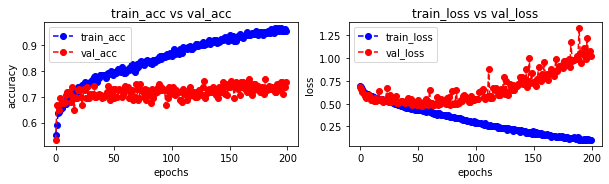

In [48]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_8)

## Adding drop layers to address the overfitting 

In [49]:
# create CNN model# 9 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01), input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=8, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))

model.add(layers.Flatten())
model.add(layers.Dense(12, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_9 = model.fit(train_images_4, train_labels_4, epochs=150, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/150
30/30 [==============================] - 3s 110ms/step - loss: 1.4311 - accuracy: 0.4555 - val_loss: 1.2338 - val_accuracy: 0.5312
Epoch 2/150
30/30 [==============================] - 2s 83ms/step - loss: 1.2061 - accuracy: 0.5064 - val_loss: 1.1712 - val_accuracy: 0.5312
Epoch 3/150
30/30 [==============================] - 3s 84ms/step - loss: 1.1429 - accuracy: 0.5339 - val_loss: 1.1145 - val_accuracy: 0.5312
Epoch 4/150
30/30 [==============================] - 3s 84ms/step - loss: 1.0889 - accuracy: 0.5593 - val_loss: 1.0654 - val_accuracy: 0.5312
Epoch 5/150
30/30 [==============================] - 3s 84ms/step - loss: 1.0425 - accuracy: 0.5508 - val_loss: 1.0229 - val_accuracy: 0.5312
Epoch 6/150
30/30 [==============================] - 3s 83ms/step - loss: 1.0006 - accuracy: 0.5699 - val_loss: 0.9866 - val_accuracy: 0.5312
Epoch 7/150
30/30 [==============================] - 2s 82ms/step - loss: 0.9677 - accuracy: 0.5646 - val_loss: 0.9554 - val_accuracy: 0.5312
Epoch

Epoch 58/150
30/30 [==============================] - 2s 81ms/step - loss: 0.5397 - accuracy: 0.7722 - val_loss: 0.8760 - val_accuracy: 0.5312
Epoch 59/150
30/30 [==============================] - 2s 82ms/step - loss: 0.5468 - accuracy: 0.7691 - val_loss: 0.9057 - val_accuracy: 0.5312
Epoch 60/150
30/30 [==============================] - 3s 84ms/step - loss: 0.5233 - accuracy: 0.7892 - val_loss: 0.9060 - val_accuracy: 0.5312
Epoch 61/150
30/30 [==============================] - 3s 88ms/step - loss: 0.5231 - accuracy: 0.7712 - val_loss: 0.9079 - val_accuracy: 0.5312
Epoch 62/150
30/30 [==============================] - 3s 102ms/step - loss: 0.5191 - accuracy: 0.7765 - val_loss: 0.9313 - val_accuracy: 0.5312
Epoch 63/150
30/30 [==============================] - 3s 86ms/step - loss: 0.5231 - accuracy: 0.7775 - val_loss: 0.9351 - val_accuracy: 0.5312
Epoch 64/150
30/30 [==============================] - 3s 87ms/step - loss: 0.5114 - accuracy: 0.7839 - val_loss: 0.8879 - val_accuracy: 0.531

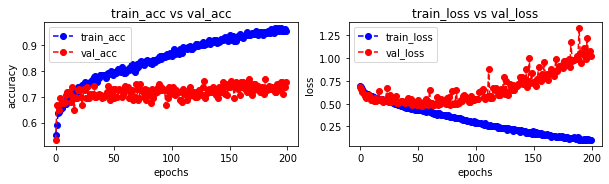

In [50]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_8)

## Adjusting filters

In [51]:
# create CNN model# 10  
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01), input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=20, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=20, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))

model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_10 = model.fit(train_images_4, train_labels_4, epochs=150, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/150
30/30 [==============================] - 8s 270ms/step - loss: 1.8716 - accuracy: 0.5265 - val_loss: 1.6875 - val_accuracy: 0.5312
Epoch 2/150
30/30 [==============================] - 7s 237ms/step - loss: 1.5850 - accuracy: 0.5392 - val_loss: 1.4716 - val_accuracy: 0.5312
Epoch 3/150
30/30 [==============================] - 7s 236ms/step - loss: 1.3927 - accuracy: 0.5561 - val_loss: 1.3197 - val_accuracy: 0.5312
Epoch 4/150
30/30 [==============================] - 7s 240ms/step - loss: 1.2560 - accuracy: 0.5900 - val_loss: 1.2070 - val_accuracy: 0.5312
Epoch 5/150
30/30 [==============================] - 8s 256ms/step - loss: 1.1558 - accuracy: 0.5657 - val_loss: 1.1194 - val_accuracy: 0.5312
Epoch 6/150
30/30 [==============================] - 7s 220ms/step - loss: 1.0702 - accuracy: 0.5858 - val_loss: 1.0543 - val_accuracy: 0.5312
Epoch 7/150
30/30 [==============================] - 7s 230ms/step - loss: 0.9936 - accuracy: 0.6081 - val_loss: 1.0018 - val_accuracy: 0.5312

Epoch 58/150
30/30 [==============================] - 6s 185ms/step - loss: 0.5023 - accuracy: 0.7966 - val_loss: 0.6628 - val_accuracy: 0.6313
Epoch 59/150
30/30 [==============================] - 6s 215ms/step - loss: 0.5178 - accuracy: 0.7797 - val_loss: 0.6928 - val_accuracy: 0.5813
Epoch 60/150
30/30 [==============================] - 7s 247ms/step - loss: 0.5041 - accuracy: 0.7828 - val_loss: 0.6821 - val_accuracy: 0.6125
Epoch 61/150
30/30 [==============================] - 8s 278ms/step - loss: 0.5119 - accuracy: 0.7797 - val_loss: 0.6865 - val_accuracy: 0.5875
Epoch 62/150
30/30 [==============================] - 8s 252ms/step - loss: 0.5083 - accuracy: 0.7765 - val_loss: 0.6732 - val_accuracy: 0.6313
Epoch 63/150
30/30 [==============================] - 8s 271ms/step - loss: 0.5040 - accuracy: 0.7828 - val_loss: 0.6870 - val_accuracy: 0.5938
Epoch 64/150
30/30 [==============================] - 9s 295ms/step - loss: 0.4950 - accuracy: 0.7892 - val_loss: 0.6689 - val_accuracy:

## Raising filters 

In [53]:
# create CNN model# 11 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=120, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01), input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=90, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=60, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=40, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_11 = model.fit(train_images_4, train_labels_4, epochs=150, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/150
30/30 [==============================] - 14s 459ms/step - loss: 2.5356 - accuracy: 0.5095 - val_loss: 1.9378 - val_accuracy: 0.5312
Epoch 2/150
30/30 [==============================] - 13s 447ms/step - loss: 1.6519 - accuracy: 0.5508 - val_loss: 1.4172 - val_accuracy: 0.5312
Epoch 3/150
30/30 [==============================] - 13s 446ms/step - loss: 1.2839 - accuracy: 0.5826 - val_loss: 1.1775 - val_accuracy: 0.5312
Epoch 4/150
30/30 [==============================] - 13s 446ms/step - loss: 1.0946 - accuracy: 0.5752 - val_loss: 1.0398 - val_accuracy: 0.5312
Epoch 5/150
30/30 [==============================] - 13s 419ms/step - loss: 0.9602 - accuracy: 0.6038 - val_loss: 0.9512 - val_accuracy: 0.5312
Epoch 6/150
30/30 [==============================] - 13s 428ms/step - loss: 0.9001 - accuracy: 0.5540 - val_loss: 0.8784 - val_accuracy: 0.5312
Epoch 7/150
30/30 [==============================] - 13s 442ms/step - loss: 0.8313 - accuracy: 0.5943 - val_loss: 0.8375 - val_accuracy:

30/30 [==============================] - 12s 384ms/step - loss: 0.5128 - accuracy: 0.7786 - val_loss: 0.6828 - val_accuracy: 0.6062
Epoch 114/150
30/30 [==============================] - 11s 358ms/step - loss: 0.5085 - accuracy: 0.7881 - val_loss: 0.6919 - val_accuracy: 0.5875
Epoch 115/150
30/30 [==============================] - 11s 381ms/step - loss: 0.5097 - accuracy: 0.7850 - val_loss: 0.6788 - val_accuracy: 0.6250
Epoch 116/150
30/30 [==============================] - 11s 375ms/step - loss: 0.5029 - accuracy: 0.7892 - val_loss: 0.6756 - val_accuracy: 0.6250
Epoch 117/150
30/30 [==============================] - 12s 383ms/step - loss: 0.4983 - accuracy: 0.7987 - val_loss: 0.6611 - val_accuracy: 0.7063
Epoch 118/150
30/30 [==============================] - 11s 371ms/step - loss: 0.4894 - accuracy: 0.7956 - val_loss: 0.6855 - val_accuracy: 0.6062
Epoch 119/150
30/30 [==============================] - 11s 378ms/step - loss: 0.5004 - accuracy: 0.7797 - val_loss: 0.6940 - val_accuracy:

## Lower the filters 

In [54]:
# create CNN model# 12 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=10, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01), input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=20, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=40, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.8))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=80, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_12 = model.fit(train_images_4, train_labels_4, epochs=100, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/100
30/30 [==============================] - 3s 99ms/step - loss: 3.3327 - accuracy: 0.5286 - val_loss: 2.7538 - val_accuracy: 0.5312
Epoch 2/100
30/30 [==============================] - 2s 79ms/step - loss: 2.3575 - accuracy: 0.5297 - val_loss: 1.9850 - val_accuracy: 0.5312
Epoch 3/100
30/30 [==============================] - 2s 75ms/step - loss: 1.7401 - accuracy: 0.5699 - val_loss: 1.5263 - val_accuracy: 0.5312
Epoch 4/100
30/30 [==============================] - 2s 74ms/step - loss: 1.3746 - accuracy: 0.5720 - val_loss: 1.2578 - val_accuracy: 0.5312
Epoch 5/100
30/30 [==============================] - 2s 77ms/step - loss: 1.1190 - accuracy: 0.6409 - val_loss: 1.0950 - val_accuracy: 0.5312
Epoch 6/100
30/30 [==============================] - 3s 84ms/step - loss: 0.9814 - accuracy: 0.6504 - val_loss: 1.0347 - val_accuracy: 0.5312
Epoch 7/100
30/30 [==============================] - 2s 77ms/step - loss: 0.8670 - accuracy: 0.6854 - val_loss: 0.9721 - val_accuracy: 0.5312
Epoch 

## Low filters in the last model resulted in bad scores, lifting the filters.

In [55]:
# create CNN model# 7 

model = models.Sequential()
model.add(layers.Conv2D(filters=200, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01), input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=90, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.6))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=90, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dropout(rate=.6))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=90, kernel_size=(2, 2), activation='relu', kernel_regularizer=l2(l2=0.01)))

model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu', kernel_regularizer=l2(l2=0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_13 = model.fit(train_images_4, train_labels_4, epochs=50, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/50
30/30 [==============================] - 13s 443ms/step - loss: 2.8995 - accuracy: 0.5307 - val_loss: 2.0120 - val_accuracy: 0.6187
Epoch 2/50
30/30 [==============================] - 13s 425ms/step - loss: 1.5650 - accuracy: 0.5858 - val_loss: 1.2289 - val_accuracy: 0.5312
Epoch 3/50
30/30 [==============================] - 14s 453ms/step - loss: 1.0586 - accuracy: 0.5826 - val_loss: 0.9429 - val_accuracy: 0.5312
Epoch 4/50
30/30 [==============================] - 13s 422ms/step - loss: 0.8570 - accuracy: 0.6229 - val_loss: 0.8276 - val_accuracy: 0.6125
Epoch 5/50
30/30 [==============================] - 12s 404ms/step - loss: 0.7680 - accuracy: 0.6335 - val_loss: 0.7651 - val_accuracy: 0.5688
Epoch 6/50
30/30 [==============================] - 13s 419ms/step - loss: 0.7017 - accuracy: 0.6653 - val_loss: 0.7330 - val_accuracy: 0.6187
Epoch 7/50
30/30 [==============================] - 13s 435ms/step - loss: 0.6691 - accuracy: 0.6896 - val_loss: 0.7459 - val_accuracy: 0.5312

## Lifting kernels and pooling to improve scores
               

In [13]:
# CNN model # Final model on traing and val               
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=88, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Dropout(rate=.6))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Dropout(rate=.6))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_14 = model.fit(train_images_4, train_labels_4, epochs=80, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/80
30/30 [==============================] - 10s 335ms/step - loss: 0.7987 - accuracy: 0.5254 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 2/80
30/30 [==============================] - 10s 328ms/step - loss: 0.6938 - accuracy: 0.5657 - val_loss: 0.6864 - val_accuracy: 0.5437
Epoch 3/80
30/30 [==============================] - 10s 326ms/step - loss: 0.7275 - accuracy: 0.5699 - val_loss: 0.6783 - val_accuracy: 0.6562
Epoch 4/80
30/30 [==============================] - 9s 305ms/step - loss: 0.6822 - accuracy: 0.6292 - val_loss: 0.6884 - val_accuracy: 0.5312
Epoch 5/80
30/30 [==============================] - 9s 310ms/step - loss: 0.6479 - accuracy: 0.6303 - val_loss: 0.6751 - val_accuracy: 0.5938
Epoch 6/80
30/30 [==============================] - 10s 329ms/step - loss: 0.6571 - accuracy: 0.6303 - val_loss: 0.6066 - val_accuracy: 0.6562
Epoch 7/80
30/30 [==============================] - 10s 332ms/step - loss: 0.6245 - accuracy: 0.6653 - val_loss: 0.6336 - val_accuracy: 0.7063
E

# Final model running on the unseen Test DATA

In [53]:
# CNN model # 15             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=88, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Dropout(rate=.6))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Dropout(rate=.6))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

history_15 = model.fit(test_images_4, test_labels_4, epochs=80, batch_size=32)

Epoch 1/80
8/8 [==============================] - 2s 246ms/step - loss: 1.1211 - accuracy: 0.5702
Epoch 2/80
8/8 [==============================] - 2s 236ms/step - loss: 0.7090 - accuracy: 0.5447
Epoch 3/80
8/8 [==============================] - 2s 224ms/step - loss: 0.6865 - accuracy: 0.5830
Epoch 4/80
8/8 [==============================] - 2s 224ms/step - loss: 0.6810 - accuracy: 0.6085
Epoch 5/80
8/8 [==============================] - 2s 228ms/step - loss: 0.6996 - accuracy: 0.5532
Epoch 6/80
8/8 [==============================] - 2s 232ms/step - loss: 0.6958 - accuracy: 0.5660
Epoch 7/80
8/8 [==============================] - 2s 240ms/step - loss: 0.6771 - accuracy: 0.6085
Epoch 8/80
8/8 [==============================] - 2s 231ms/step - loss: 0.6892 - accuracy: 0.6298
Epoch 9/80
8/8 [==============================] - 2s 219ms/step - loss: 0.6936 - accuracy: 0.5404
Epoch 10/80
8/8 [==============================] - 2s 223ms/step - loss: 0.6718 - accuracy: 0.6213
Epoch 11/80
8/8 [==

## Evaluation
We will use accuaracy scores as our metric because we want the model correct on both spectrums, little to no false negatives and little to no false positives, if the autonomous accuaracy is off in either direction it could results in hazards and accidents, remember we our task is to make the roads safer. 

Final model has training accuracy score of 98 and validation of 75, we see this as overfit but not and issue we believe these outcomes are a result of small validation sample (160) and traing of a much larger sample (944), the testing data is larger (235) then the validation and will be promising.

Once tuning the training and validation model reach optimization I will train on unseen data (testing data).
The result scores are promising and will make a postive impact on the models predicting person or person like and ultimately will give the autonomous vechile the technology to self drive safely and pass government regulation standards for deployment in real world applications.   

Best model based on evalution of 15 + models, the final model will perform best in real world application.
This model minimized its error and has tolerable False negatives and false postivies. 
Once the model scores are final I will build the slide deck with the findings of the model performance.

In [58]:
test_scores = model.evaluate(test_images_4, test_labels_4)

8/8 [==============================] - 1s 69ms/step - loss: 0.0086 - accuracy: 1.0000


In [66]:
# reviewing  params 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 50, 50, 64)        4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 88)        140888    
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 88)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 88)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 5, 5, 96)          211296    
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 96)         

In [ ]:
# saving of prediciton object on test 
preds = model.predict(test_images_4) 

In [46]:
# changing preds floats to binary class 1 or zero 

pred_ped = []

for i in preds:
    if i > .5:
        pred_ped.append(1)
    else:
        pred_ped.append(0)
    
    

In [47]:
# binary class review 1 and zero
pred_ped

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]

In [67]:
# review the confusion matrix to see how many times my model was wrong(fp,fn) or right ( tp,tn)
confusion_matrix(test_labels_4,pred_ped)

array([[111,  25],
       [ 49,  50]], dtype=int64)

In [68]:
# exploring different ways to review results 
tn, fp, fn, tp = confusion_matrix(test_labels_4,pred_ped).ravel()

In [69]:
(tn, fp, fn, tp)

(111, 25, 49, 50)

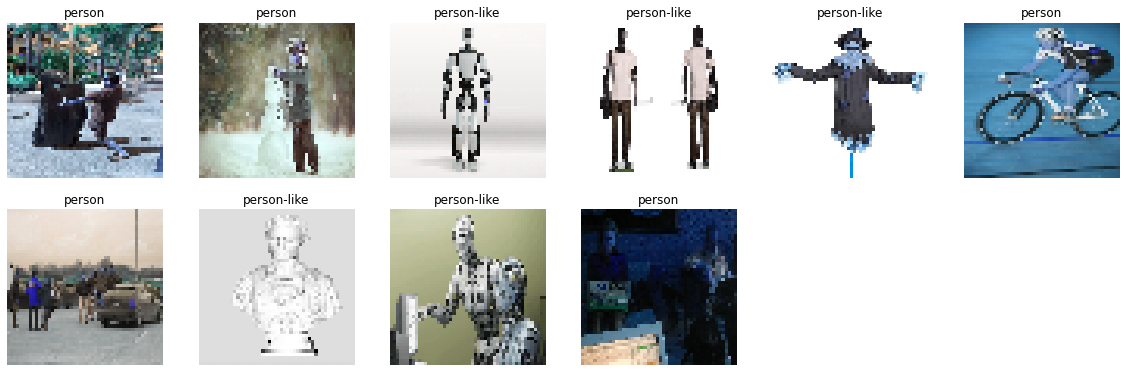

In [26]:
# prediction visual on the images 

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(pred_ped),10))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(test_images_4[i])
    plt.title(classes[pred_ped[i]])
    plt.axis('off')


## Conclusion
Results of the final model were satisyfing with a score of 98% our client will ultimately pass the governemnt and state regulations and gain approval for a real world application for autonomous vehicles. Training a model on person / person like has a significent positive impact on pedestrian detection for autonomous driving applications. 

PARAMS - 660,000

Accuracy - 98%


## Future Insights

-License deal with automotive manufacturers.

-Autonomous robot delievery system and application.

-Logistic field research on new projects.

-I have concluded the results and optimized the model ready for deployment, 
The model we be deployed Via streamlit.

